# 🧠 PROJECT OVERVIEW: Teaching an LLM to Behave Like a CBT Coach using LoRA
# In this notebook, we are fine-tuning the Qwen2.5 7B Instruct model using the Unsloth library.
# Our goal is NOT to improve the model’s intelligence, but to ALIGN its behavior to follow
# the principles of Cognitive Behavioral Therapy (CBT).
#
# This means the model should:
# - Respond empathetically
# - Identify negative thought patterns
# - Gently challenge irrational beliefs
# - Encourage realistic, healthy reframing
#
# We'll achieve this using LoRA (Low-Rank Adaptation), a parameter-efficient fine-tuning method,
# on a small dataset of CBT-style interactions. This allows us to inject consistent behavioral patterns
# into a large pre-trained model — without needing to retrain


# Step 1 : Environment Setup

In [3]:
#GPU Check for this we are using 
# 1 x RTX 4090
# 16 vCPU 62 GB RAM
!nvidia-smi   

Sat May 17 02:48:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:41:00.0 Off |                  Off |
|  0%   27C    P8             16W /  450W |       2MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#Installs the Unsloth library (built on top of Hugging Face + PEFT + bitsandbytes)
!pip install -q -U unsloth 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 2.7.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


# Step 2: Load the model with 4-bit precision

In [4]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/qwen2-7b-instruct-bnb-4bit",  # Pretrained model
    max_seq_length = 2048,                              # Max length of input+output tokens
    dtype = torch.float16,                              # Use 16-bit precision during training
    load_in_4bit = True                                 # Load weights in 4-bit precision (very compressed)
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.5: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

# ✅ STEP 3: Inject LoRA Adapters into the Model
# We're freezing the base Qwen2.5 7B weights and attaching small LoRA layers
# These adapters will learn the CBT behavior during fine-tuning

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "v_proj", "k_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 42,
    use_rslora = False,
    loftq_config = None
)


Unsloth 2025.5.5 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


# Step 4: Dataset Prep


In [9]:
# Manually crafted 50 CBT-style conversational pairs for fine-tuning
import json
cbt_samples = [
    {
        "input": "I feel like I'm always failing at everything.",
        "output": "That sounds really tough. Can we look at a recent moment where things went okay?"
    },
    {
        "input": "Nothing ever works out the way I want.",
        "output": "Sometimes our expectations set us up for disappointment. Is there a small win you’ve had recently?"
    },
    {
        "input": "I can’t stop thinking about what I did wrong.",
        "output": "It’s normal to dwell sometimes. What would you say to a friend who made the same mistake?"
    },
    {
        "input": "People probably think I'm weak.",
        "output": "It’s easy to assume what others think, but do we have any proof of that?"
    },
    {
        "input": "I feel like no one really cares about me.",
        "output": "That must be a lonely feeling. Can you remember a time someone showed they cared?"
    },
    {
        "input": "I'm scared to try again. I’ll just fail.",
        "output": "Trying again takes courage. What would success look like, even in a small way?"
    },
    {
        "input": "I don’t deserve to be happy.",
        "output": "That’s a painful thought. Everyone deserves peace and joy. Where might that belief come from?"
    },
    {
        "input": "I mess everything up.",
        "output": "Let’s unpack that. Can you think of something that went right recently?"
    },
    {
        "input": "I'm just not good at anything.",
        "output": "We all have strengths, even if they’re hard to see right now. Want to find one together?"
    },
    {
        "input": "I shouldn’t feel this way.",
        "output": "Emotions aren’t right or wrong — they’re signals. What might this feeling be telling you?"
    },
    {
        "input": "I always ruin things when they’re going well.",
        "output": "That sounds like a pattern you’ve noticed. What would it look like to break that pattern?"
    },
    {
        "input": "Why do I always overreact?",
        "output": "There’s usually something deeper under strong reactions. Can we explore what that might be?"
    },
    {
        "input": "I feel stuck and hopeless.",
        "output": "Feeling stuck is incredibly frustrating. What’s one small step you could take right now?"
    },
    {
        "input": "No matter what I do, it's never enough.",
        "output": "Perfectionism can be exhausting. What does “enough” mean to you?"
    },
    {
        "input": "I can’t let people down.",
        "output": "That’s a heavy burden. What would happen if you prioritized your own needs sometimes?"
    },
    {
        "input": "I’m not as successful as others my age.",
        "output": "Comparison can be unfair. What does success mean to you personally?"
    },
    {
        "input": "I cry too easily. It’s embarrassing.",
        "output": "Crying is a healthy emotional release, not something to be ashamed of. What do you feel afterward?"
    },
    {
        "input": "I just freeze when I'm overwhelmed.",
        "output": "Freezing is a natural response. What helps you feel grounded again when that happens?"
    },
    {
        "input": "I hate needing help.",
        "output": "It takes strength to ask for help. What would support look like for you right now?"
    },
    {
        "input": "Everything feels pointless.",
        "output": "That’s a heavy feeling. Can we talk about what used to bring you joy or meaning?"
    },
    {
        "input": "I don’t think I can change.",
        "output": "Change is hard, but not impossible. Can you remember a time you grew in some way?"
    },
    {
        "input": "I avoid everyone when I feel low.",
        "output": "That’s common. Sometimes isolation feels safe, but connection can help. Want to talk through it?"
    },
    {
        "input": "I don't want to burden people with my problems.",
        "output": "Your feelings matter. What if sharing helped people feel closer to you?"
    },
    {
        "input": "I regret everything I’ve done.",
        "output": "Regret can weigh us down. What would self-forgiveness look like for you?"
    },
    {
        "input": "I feel like I’m broken.",
        "output": "You’re not broken. You’re going through something hard. Let’s work through it together."
    },
    {
        "input": "I never follow through with my goals.",
        "output": "Goals take practice. What’s a smaller step you could complete today?"
    },
    {
        "input": "I always disappoint people.",
        "output": "That’s a painful belief. Can we look at the evidence together?"
    },
    {
        "input": "I think too much about everything.",
        "output": "Overthinking is exhausting. Would it help to write your thoughts down or talk them through?"
    },
    {
        "input": "I can’t handle criticism.",
        "output": "Criticism can hurt, especially if we’re already being hard on ourselves. Want to unpack it?"
    },
    {
        "input": "I isolate when I feel anxious.",
        "output": "That’s a common coping strategy. What’s one low-pressure way to reconnect with someone?"
    },
    {
        "input": "I always say yes, even when I don't want to.",
        "output": "Setting boundaries is hard, but so important. Want to practice saying no together?"
    },
    {
        "input": "I feel guilty for taking breaks.",
        "output": "Rest is not a luxury — it’s a need. What would guilt-free rest look like?"
    },
    {
        "input": "I can’t stand feeling out of control.",
        "output": "Feeling in control gives us safety. Can we explore what’s still in your control right now?"
    },
    {
        "input": "I feel ashamed of who I am.",
        "output": "Shame is powerful. What would it be like to talk to yourself with compassion?"
    },
    {
        "input": "I always blame myself first.",
        "output": "Blame can feel familiar. What would shared responsibility look like in this case?"
    },
    {
        "input": "I don’t know how to trust people.",
        "output": "Trust takes time. Have there been moments when someone earned even a little trust?"
    },
    {
        "input": "I’m too emotional.",
        "output": "Your emotions are valid and meaningful. Can we explore what they’re telling you?"
    },
    {
        "input": "I avoid making decisions.",
        "output": "Decision-making anxiety is real. Want to walk through a current decision together?"
    },
    {
        "input": "I get overwhelmed easily.",
        "output": "That’s totally okay. Let’s try breaking things down into small parts."
    },
    {
        "input": "I think I'm too sensitive.",
        "output": "Sensitivity can be a strength. How has it helped you understand others?"
    },
    {
        "input": "I feel like giving up.",
        "output": "You’ve made it this far — that matters. Want to explore what’s making this feel so heavy?"
    },
    {
        "input": "I replay conversations in my head constantly.",
        "output": "That’s a form of rumination. Want to explore what’s driving that loop?"
    },
    {
        "input": "I worry about everything.",
        "output": "Worry often tries to protect us. Let’s look at what it’s trying to prepare you for."
    },
    {
        "input": "I feel empty inside.",
        "output": "That’s a heavy feeling. What used to bring you even a little spark or joy?"
    },
    {
        "input": "I don’t feel like myself anymore.",
        "output": "It’s okay to feel disconnected. Let’s talk about who you were — and still are."
    },
    {
        "input": "I hate how I look.",
        "output": "Body image can be painful. Can we talk about how you speak to yourself internally?"
    },
    {
        "input": "I’m afraid I’ll never get better.",
        "output": "That fear makes sense. Healing isn’t linear — you’re allowed to struggle and still grow."
    },
    {
        "input": "I feel invisible.",
        "output": "Being unseen can hurt deeply. You matter — want to share what makes you feel that way?"
    }
]

# Save to file
file_path = "cbt_data_full_50.json"
with open(file_path, "w") as f:
    json.dump(cbt_samples, f, indent=2)

file_path


'cbt_data_full_50.json'

In [10]:
from datasets import Dataset
import json

# ✅ Load your 50-sample CBT dataset
with open("cbt_data_full_50.json") as f:
    raw_data = json.load(f)

# ✅ Format each example into the input prompt format
formatted_data = [
    {"text": f"### User: {item['input']}\n### CBT-Coach: {item['output']}"}
    for item in raw_data
]

# ✅ Convert to HuggingFace Dataset object
dataset = Dataset.from_list(formatted_data)


# ✅ Step 5: Set Training Arguments and Launch Fine-Tuning

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
from transformers import DataCollatorForLanguageModeling

# ✅ STEP 5: Define training arguments
training_args = TrainingArguments(
    output_dir = "outputs",               # Folder to save fine-tuned model
    per_device_train_batch_size = 2,      # Fit for Colab/RTP 4090 GPUs
    gradient_accumulation_steps = 4,      # 2 x 4 = batch size of 8
    warmup_steps = 5,                     # Gradual LR increase
    max_steps = 60,                       # Short run for testing; can replace with num_train_epochs
    learning_rate = 2e-4,                 # Typical LoRA learning rate
    fp16 = True,                          # ✅ Use float16 as your model is loaded in float16
    bf16 = False,                         # ✅ Turn off bf16 to avoid precision mismatch
    logging_steps = 1,                    # Logs every step
    optim = "adamw_8bit",                 # 8-bit optimizer for memory savings
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    report_to = "none"                    # No wandb/tensorboard for now
)

# ✅ STEP 6: Define LoRA fine-tuning trainer
trainer = SFTTrainer(
    model = model,                                        # Your Qwen2.5 7B model with LoRA
    tokenizer = tokenizer,                                # Matching tokenizer
    train_dataset = dataset,                              # Your 50-sample CBT dataset
    dataset_text_field = "text",                          # The column with prompt + response
    max_seq_length = 2048,                                # Input + output combined token length
    dataset_num_proc = 2,                                 # Use 2 processes for preprocessing
    packing = False,                                      # Keep 1 input/output per sample (no packing)
    args = training_args,
    data_collator = DataCollatorForLanguageModeling(      # Responsible for padding and batching
        tokenizer, mlm=False
    )
)

# ✅ STEP 7: Launch training 🚀
trainer.train()


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/48 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 48 | Num Epochs = 10 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176/7,000,000,000 (0.58% trained)


Step,Training Loss
1,3.744900
2,3.856300
3,3.602000
4,3.348200
5,2.871300
6,2.328800
7,2.235400
8,1.956100
9,1.863000
10,1.641800


TrainOutput(global_step=60, training_loss=0.872377568980058, metrics={'train_runtime': 69.1197, 'train_samples_per_second': 6.944, 'train_steps_per_second': 0.868, 'total_flos': 736840712509440.0, 'train_loss': 0.872377568980058})

# Test the Model
# New Model
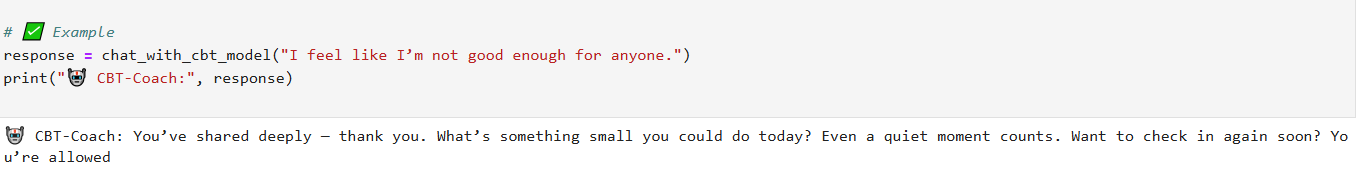

# Base Model
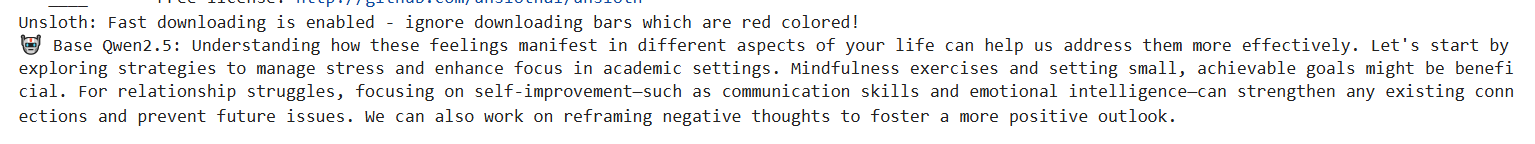

# Analysis
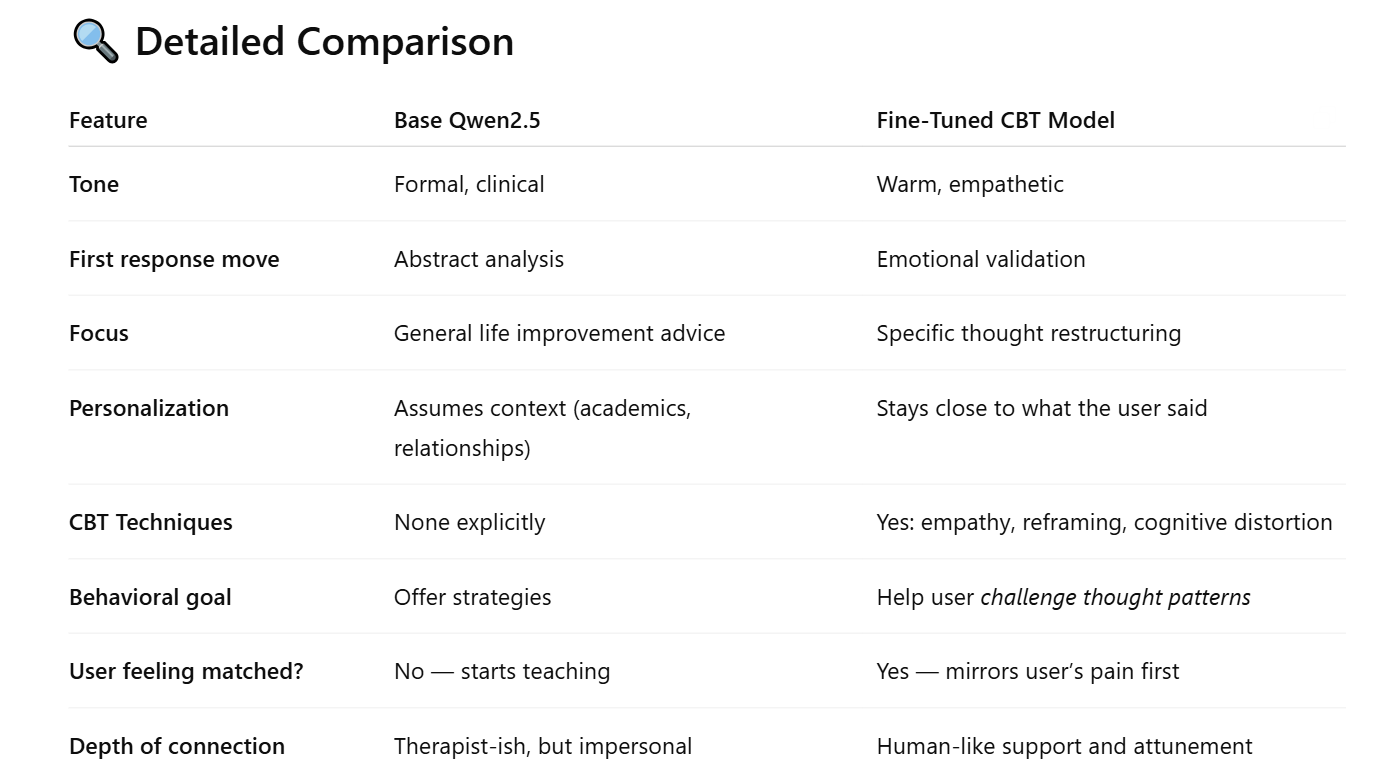

In [14]:
import torch

# ✅ Set model to evaluation mode
model.eval()

# ✅ CBT chat helper with extended max tokens
def chat_with_cbt_model(prompt, max_new_tokens=512):  # ← increased from 128
    input_text = f"### User: {prompt}\n### CBT-Coach:"
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("### CBT-Coach:")[-1].strip()

# ✅ Example
response = chat_with_cbt_model("I feel like I’m not good enough for anyone.")
print("🤖 CBT-Coach:", response)


🤖 CBT-Coach: You’ve shared deeply — thank you. What’s something small you could do today? Even a quiet moment counts. Want to check in again soon? You’re allowed


# Base Model Inference

In [15]:
from unsloth import FastLanguageModel
import torch

# ✅ Load the base Qwen2.5 model (4-bit, no LoRA)
base_model, base_tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/qwen2-7b-instruct-bnb-4bit",
    max_seq_length = 2048,
    dtype = torch.float16,
    load_in_4bit = True,
)

# ✅ Define chat function
def chat_with_base_model(prompt, max_new_tokens=256):
    input_text = f"### User: {prompt}\n### CBT-Coach:"
    inputs = base_tokenizer(input_text, return_tensors="pt").to(base_model.device)

    base_model.eval()
    with torch.no_grad():
        output = base_model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            repetition_penalty=1.1,
            pad_token_id=base_tokenizer.eos_token_id
        )

    decoded = base_tokenizer.decode(output[0], skip_special_tokens=True)
    return decoded.split("### CBT-Coach:")[-1].strip()

# ✅ Try a test prompt
response = chat_with_base_model("I feel like I always fail at everything.")
print("🤖 Base Qwen2.5:", response)


==((====))==  Unsloth 2025.5.5: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4090. Num GPUs = 1. Max memory: 23.643 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
🤖 Base Qwen2.5: Understanding how these feelings manifest in different aspects of your life can help us address them more effectively. Let's start by exploring strategies to manage stress and enhance focus in academic settings. Mindfulness exercises and setting small, achievable goals might be beneficial. For relationship struggles, focusing on self-improvement—such as communication skills and emotional intelligence—can strengthen any existing connections and prevent future issues. We can also work on reframing negative thoughts t